# Neural flux limiter demo

In this demo we introduce the concept of flux limiter based on linear advection equation. Then we illustrate the framework of learning second-order TVD flux limiter through differentiable finite volume solvers.

In [1]:
import os
import time
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, lax
from jax import random
import functools
import flax.linen as nn
from flax.training import train_state
import optax

jax.config.update("jax_enable_x64", True)

from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, compose

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors()
plt.rcParams['font.family'] = 'DejaVu Sans'

# Problem setup

## Linear advection

Consider the numerical solution of the one-dimensional linear advection governed by the hyperbolic conservation law:
\begin{equation}
    \frac{\partial u}{\partial t} + \frac{\partial (au)}{\partial x} = 0,
\end{equation}
where $u = u(x,t)$ denotes the state and $a$ is the advection velocity. Without loss of generality, we assume that the velocity is positive ($a>0$). In numerical discretization of the above equation based on the finite volume method (FVM), we denote $\Delta t$ as the time step and $\Delta x$ as the cell size. Due to the stability requirement, the CFL number, $\nu = a\Delta t/\Delta x$, is limited to the range of $(0,1]$.

## Flux limiter

We review two numerical schemes for solving the linear advection equation, namely the first-order upwind scheme and the Lax-Wendroff scheme.
\begin{equation}
    \begin{aligned}
        F_{i+\frac{1}{2}}^{FOU} &= au_i, \\
        F_{i+\frac{1}{2}}^{LW} &= au_i + \frac{a}{2}(1-\nu)(u_{i+1}-u_i).
    \end{aligned}
\end{equation}

Then we introduce a flux limiter $\phi_{i+\frac{1}{2}}$, which combines these two fluxes and gives the modified flux as
\begin{equation}
    F = (1-\phi_{i+\frac{1}{2}})F_{i+\frac{1}{2}}^{FOU} + \phi_{i+\frac{1}{2}}F_{i+\frac{1}{2}}^{LW} = au_i + \frac{a}{2}(1-\nu)\phi_{i+\frac{1}{2}}(u_{i+1}-u_i).
\end{equation}

In fact, the flux limiter $\phi(r)$ can be interpreted as a function to limit the anti-diffusive flux in the Lax-Wendroff scheme according to the smooth measure $r$, which is the ratio of adjacent differences
\begin{equation}
    r_{i+\frac{1}{2}} = \frac{u_{i} - u_{i-1}}{u_{i+1} - u_{i}}.
\end{equation}

If $r$ is approximately equal to 1, which indicates local smoothness, we recover second-order accurate Lax-Wendroff scheme, if not, we need to limit the second-order correction term correspondingly.

According to Harten's lemma, we are able to derive the TVD region. If $r \leqslant 0$, then we are at an extremum, and we usually set $\phi(r) = 0$ in this case to achieve a TVD method. Note that for any second-order accurate method we must have $\phi(1) = 1$ to recover Lax-Wendroff scheme. Imposing this additional restriction gives us the second-order TVD region.

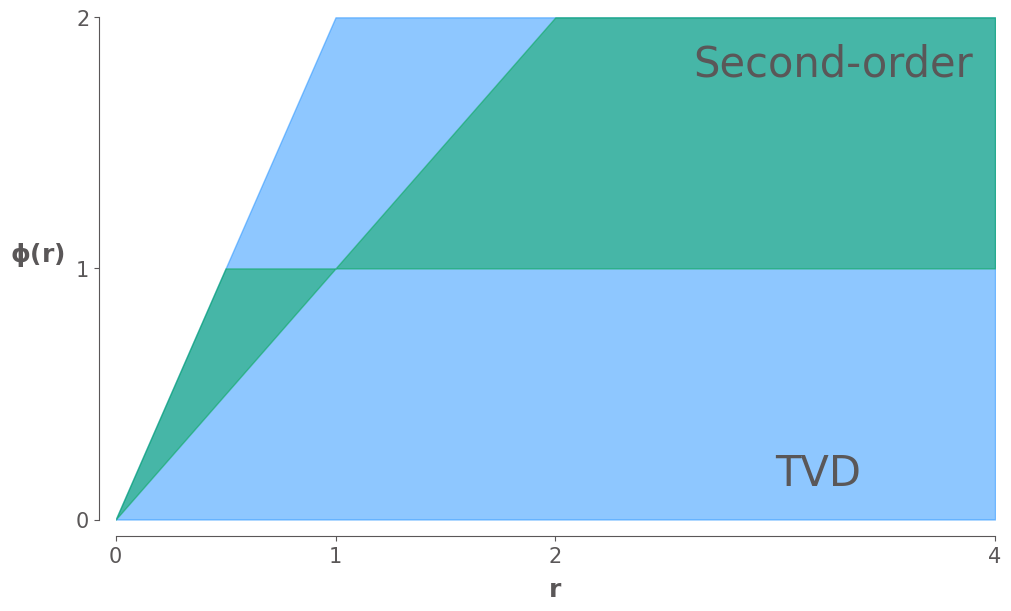

In [2]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\phi(r)$", rotation="horizontal", ha="right")

r = np.linspace(0, 4, 401)

TVDLowerBound = np.zeros_like(r)
TVDUpperBound = np.minimum(2, 2 * r)

highOrderLowerBound = np.minimum(1, r)
highOrderUpperBound = np.where(r < 1, np.minimum(2 * r, 1), np.minimum(2, r))

ax.fill_between(r, TVDLowerBound, TVDUpperBound, color=colors["Blue"], alpha=0.5, label="TVD")
ax.fill_between(r, highOrderLowerBound, highOrderUpperBound, color=colors["Green"], alpha=0.5, label="High order")
ax.annotate("TVD", xy=(3, 0.1), ha="left", va="bottom", fontsize=30)
ax.annotate("Second-order", xy=(3.9, 1.9), ha="right", va="top", fontsize=30)

ax.set_xticks([0, 1, 2, 4])
ax.set_yticks([0, 1, 2])
niceplots.adjust_spines(ax)

In [3]:
# Define several common flux limiters

def FOU(r):
    return jnp.zeros_like(r)

def LaxWendroff(r):
    return jnp.ones_like(r)

@jit
def minmod(r):
    return jnp.maximum(0., jnp.minimum(1., r))

@jit
def vanLeer(r):
    return (r + jnp.abs(r)) / (1 + jnp.abs(r))

@jit
def superbee(r):
    return jnp.maximum(jnp.maximum(0., jnp.minimum(2 * r, 1.)), jnp.minimum(r, 2.))

Now we plot three of the most common limiter curves on this plot, the equations for these limiters are given in the course notes:

* Minmod: Chooses the most diffusive value of that satisfies the TVD and second-order requirements

* Superbee: Chooses the least diffusive value of that satisfies the TVD and second-order requirements

* van Leer: A smoothly varying limiter that satisfies the TVD and second-order requirements

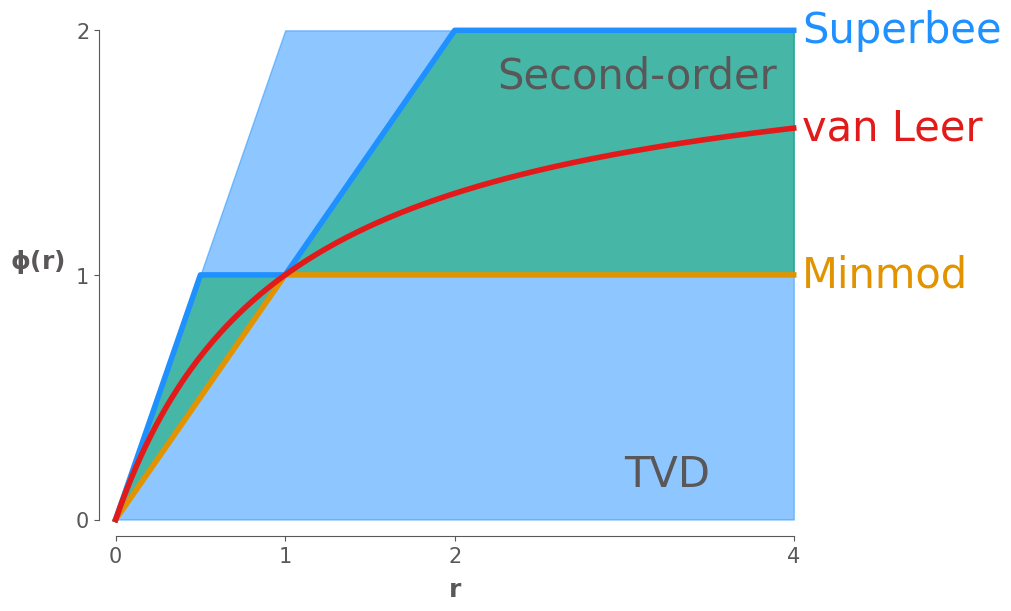

In [4]:
ax.plot(r, minmod(r), label="Minmod", lw=4, clip_on=False)
ax.plot(r, superbee(r), label="Superbee", lw=4, clip_on=False)
ax.plot(r, vanLeer(r), label="van Leer", lw=4, clip_on=False)

niceplots.label_line_ends(ax, fontsize=30)
fig

# Learning second-order TVD flux limiter via differentiable solvers

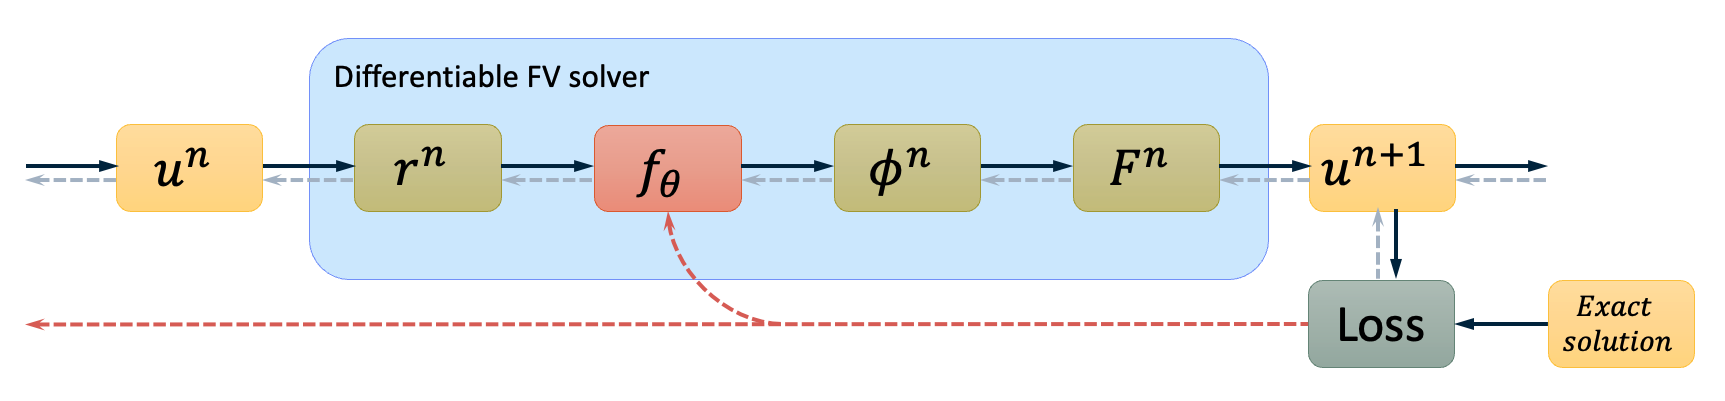

This is a schematic diagram of learning the second-order TVD flux limiters. The black solid arrows represent the forward pass to calculate the loss while the gray and red dashed arrows represent the backward pass to compute the gradients to update the parameters of the neural network $f_{\theta}$. At each time step, the smoothness measure $r^{n}$ at cell interfaces is calculated using the current states $u^{n}$. The neural network $f_{\theta}$ takes $r^{n}$ as input and outputs the value $\phi^{n}$, which is used to evaluate the second-order correction term added to the underlying first-order flux. The states $u^{n+1}$ at the next time step is then updated by the total flux $F^{n}$. The solution trajectory is propagated until prescribed time steps and the loss is evaluated with respect to the exact solution. The loss can be backpropagated through time using automatic differentiation to update the parameters of the neural flux limiter $f_{\theta}$ as all parts of the solution algorithm are fully differentiable.

## Enforce hard second-order TVD constraint
To enforce the second-order TVD constraint, we represent the flux limiter as point-wise convex linear combination of minmod and superbee, i.e.,
\begin{equation}
    \phi_{\theta}(r) = (1 - \lambda_{\theta}(r))\phi_{\text{minmod}}(r) + \lambda_{\theta}(r)\phi_{\text{superbee}}(r),
\end{equation}
where
\begin{equation}
    \lambda_{\theta}(r) = \texttt{sigmoid}(f_{\theta}(r)),
\end{equation}
where $f_{\theta}(r)$ is parametrized by an MLP with $\theta$ being the corresponding parameters. Note that the linear combination needs to be convex so that $\phi(r)$ can locate at the second-order TVD region, which means that
\begin{equation}
    \lambda_{\theta}(r) \in [0,1], \quad \forall r.
\end{equation}
To achieve this, we apply the $\texttt{sigmoid}$ activation function on the output of the MLP to get $\lambda_{\theta}(r)$.

In [5]:
class FluxLimiter(nn.Module):
    n_hidden: int
    n_output: int
    n_layers: int
    act: str

    def setup(self):
        # Set activation function
        if self.act == "relu":
            self.activation = nn.relu
        elif self.act == "tanh":
            self.activation = nn.tanh
        else:
            raise ValueError(f"Activation function type: {self.act} not implemented.")

        self.hidden = [nn.Dense(self.n_hidden) for _ in range(self.n_layers)]
        self.end = nn.Dense(self.n_output)

    def __call__(self, r):
        x = r
        for layer in self.hidden:
            x = layer(x)
            x = self.activation(x)
        x = self.end(x)
        x = nn.sigmoid(x)
        x = (1 - x) * minmod(r) + x * superbee(r)

        return x

In [6]:
def plot_neural_flux_limiter(flux_limiter, params, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    r_min = -2
    r_max = 10
    n_eval = 1000
    r_eval = jnp.linspace(r_min, r_max, n_eval)
    preds = flux_limiter.apply(params, jnp.expand_dims(r_eval, 1))
    preds = preds.squeeze()

    ax.plot(r_eval, minmod(r_eval), label="minmod", clip_on=False)
    ax.plot(r_eval, vanLeer(r_eval), label="van Leer", clip_on=False)
    ax.plot(r_eval, superbee(r_eval), label="superbee", clip_on=False)
    ax.plot(r_eval, preds, label="neural flux limiter", clip_on=False)
    ax.set_xlabel('$r$')
    ax.set_ylabel('$\phi(r)$')
    ax.legend()

    return fig, ax

## Dataset
The training datasets are generated using the code from PDEBench based on JAX. We generated 10000 trajectories with the periodic boundary condition. In our dataset, the initial condition is the superposition of two sinusoidal waves
\begin{eqnarray}
    u_0(x) = \sum_{i=1}^{2}A_i\sin(k_i x + \varphi_i),
\end{eqnarray}
where $k_i = 2\pi n_i/L_x$ are wave numbers whose $n_i$ are integer numbers selected in $[1, k_{\max}=8]$, $L_x$ is the calculation domain size, $A_i$ is a random float number uniformly chosen in $[0,1]$, and $\varphi_i$ is the randomly chosen phase in $(0, 2\pi)$.
We randomly operate the absolute value function with random signature and the window-function with 10\% probability, respectively.

In [7]:
def get_dataset(path, n_train, n_val, key):
    _dataset = jnp.float64(np.load(path))

    # Shuffle the whole dataset
    perm = random.permutation(key, _dataset.shape[0])

    dataset = {
        'train': _dataset[perm[0:n_train],:,:],
        'val': _dataset[perm[n_train:(n_train + n_val)],:,:]
    }

    ds = {}

    for split in ['train', 'val']:
        ds[split] = {
            # Initial condition only
            'x': dataset[split][:,0,:],
            # Full trajectories excluding initial condition
            'y': dataset[split][:,1:,:]
        }

    return ds['train'], ds['val']

## Solver

In [8]:
def solve_linear_advection_1D(params, u0, n_timesteps, a, dx, CFL, flux_limiter):
    """ Solve the linear advection equation
        \partial{u}/\partial{t} + a \partial{u}/\partial{x} = 0
    """

    dt = CFL * dx / a
    n_cells = len(u0)

    u_all = jnp.zeros((n_timesteps, n_cells))

    u = u0.copy()

    @jit
    def update_fn(i, carry):
        u, u_all = carry

        f = a * u

        # Compute r
        ul = jnp.roll(u, 1)
        ur = jnp.roll(u, -1)

        r = (u - ul) / (ur - u + 1e-8)
        phi = flux_limiter.apply(params, jnp.expand_dims(r, 1))
        phi = phi.squeeze()

        # First-order upwind
        F_low = 0.5 * (f + jnp.roll(f, -1)) - 0.5 * jnp.abs(a) * (jnp.roll(u, -1) - u)
        # Lax-Wendroff
        F_high = f + 0.5 * (1 - CFL) * (jnp.roll(f, -1) - f)
        F = (1 - phi) * F_low + phi * F_high
        u -= dt/dx * (F - jnp.roll(F, 1))
        u_all = u_all.at[i].set(u.copy())

        return u, u_all

    carry = u, u_all
    u, u_all = lax.fori_loop(0, n_timesteps, update_fn, carry)

    return u, u_all

## Setup ML model, training procedure, and optimizer

In [9]:
@jit
def apply_model(state, x, y):
    """Computes gradients and loss for a single batch."""

    def loss_fn(params):
        _, u_all = state.apply_fn(params, x)
        loss = jnp.mean((u_all - y)**2)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    return loss, grads

@jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [10]:
def train_epoch(state, train_ds, batch_size, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['x'])
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, train_ds_size)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        x = train_ds['x'][perm, ...]
        y = train_ds['y'][perm, ...]
        loss, grads = apply_model(state, x, y)
        state = update_model(state, grads)
        epoch_loss.append(loss)
    train_loss = np.mean(epoch_loss)
    return state, train_loss

In [11]:
def create_train_state(solver, model, rng, cfg):
    """Creates initial `TrainState`."""
    params = model.init(rng, jnp.ones([1, 1]))
    # print(params)
    tx = optax.adam(cfg.opt.lr)
    apply_fn = functools.partial(solver,
                                 n_timesteps=cfg.data.n_timesteps,
                                 a=cfg.data.velocity,
                                 dx=(cfg.data.xR - cfg.data.xL) / (cfg.data.spatial_length / cfg.data.CG),
                                 CFL=cfg.data.CFL,
                                 flux_limiter=model,
                                 )
    apply_fn = jit(vmap(apply_fn, in_axes=(None, 0)))
    return train_state.TrainState.create(apply_fn=apply_fn, params=params, tx=tx)

## Begin training

In [15]:
with initialize(version_base=None, config_path=""):
    cfg = compose(config_name='config.yaml')

    # Print the configuration to check its contents:
    print(OmegaConf.to_yaml(cfg))

net:
  n_input: 1
  n_output: 1
  n_hidden: 64
  n_layers: 5
  activation: relu
opt:
  n_epochs: 30
  lr: 0.001
  weight_decay: 0.0
  n_checkpoint: 1
data:
  folder: ''
  filename: 1D_linear_adv_beta1.0_8xCG.npy
  batch_size: 128
  n_train: 1280
  test_batch_size: 64
  n_val: 256
  spatial_length: 1024
  temporal_length: 321
  CG: 8
  xL: 0.0
  xR: 1.0
  dt: 0.000390625
  n_timesteps: 40
  t_end: 0.125
  velocity: 1.0
  CFL: 0.4
wandb:
  log: true



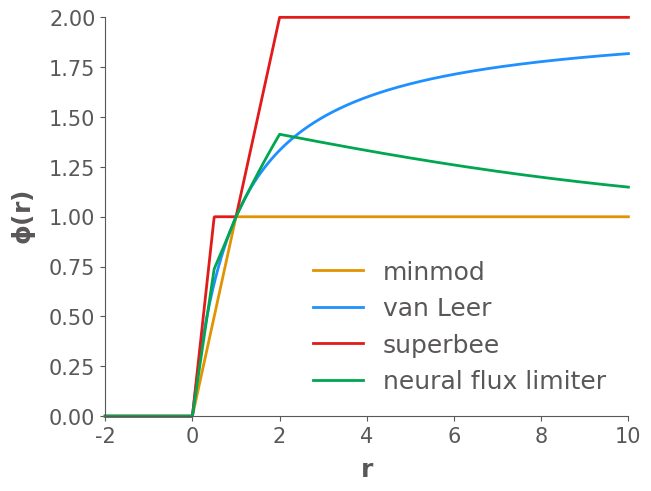

In [16]:
rng = random.key(0)
rng, init_rng = jax.random.split(rng)

flux_limiter = FluxLimiter(n_hidden=cfg.net.n_hidden,
                            n_output=cfg.net.n_output,
                            n_layers=cfg.net.n_layers,
                            act=cfg.net.activation)

state = create_train_state(solve_linear_advection_1D, flux_limiter, init_rng, cfg)

# Plot the initial flux limiter
fig, ax = plot_neural_flux_limiter(flux_limiter, state.params)

In [17]:
# Load dataset
path = cfg.data.folder
path = os.path.expanduser(path)
flnm = cfg.data.filename
path = os.path.join(path, flnm)
train_ds, val_ds = get_dataset(path=path,
                                n_train=cfg.data.n_train,
                                n_val=cfg.data.n_val,
                                key=random.key(1),
                                )

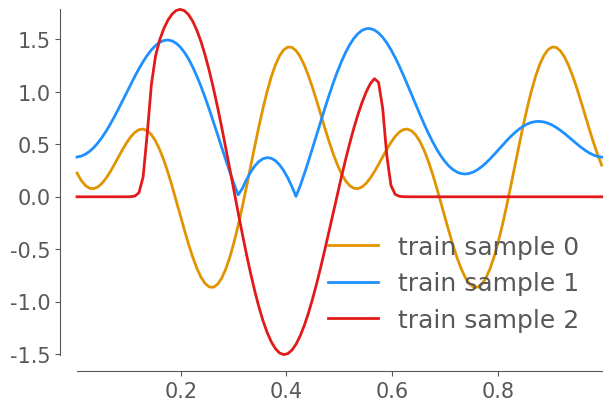

In [18]:
# Show some initial conditions in the training dataset
dx = (cfg.data.xR - cfg.data.xL) / (cfg.data.spatial_length / cfg.data.CG)
x_coordinates = jnp.linspace(cfg.data.xL+0.5*dx, cfg.data.xR-0.5*dx, int(cfg.data.spatial_length / cfg.data.CG))
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x_coordinates, train_ds['x'][12], label="train sample 0", clip_on=False)
ax.plot(x_coordinates, train_ds['x'][34], label="train sample 1", clip_on=False)
ax.plot(x_coordinates, train_ds['x'][50], label="train sample 2", clip_on=False)
ax.legend()
niceplots.adjust_spines(ax)

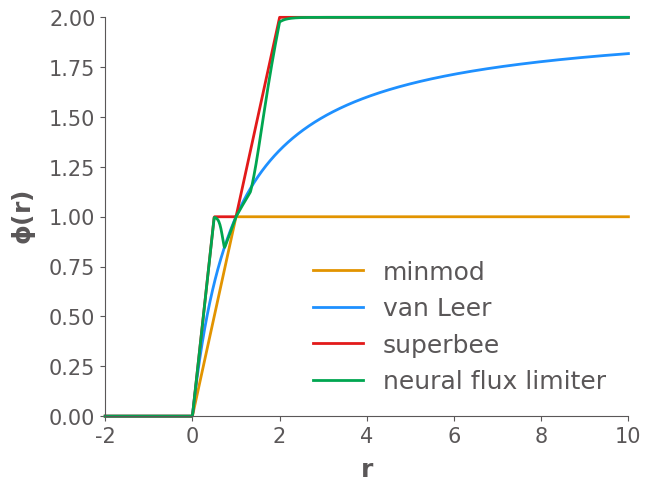

Epoch 0:
epoch time: 12.412456035614014
train loss: 8.487687623795705e-05
val loss: 0.00012061667670076023
Epoch 1:
epoch time: 11.619254112243652
train loss: 7.55013277031491e-05
val loss: 0.00011919076351721309
Epoch 2:
epoch time: 10.738573789596558
train loss: 7.506131060196191e-05
val loss: 0.0001187116982952587
Epoch 3:
epoch time: 10.691510915756226
train loss: 7.416948585381734e-05
val loss: 0.00011875399028808165
Epoch 4:
epoch time: 10.693429946899414
train loss: 7.364625703224627e-05
val loss: 0.00011737161827125262
Epoch 5:
epoch time: 10.798002243041992
train loss: 7.303017210648116e-05
val loss: 0.00011565869045087705
Epoch 6:
epoch time: 11.634629249572754
train loss: 7.212322740993493e-05
val loss: 0.00011408318389574515
Epoch 7:
epoch time: 10.991726160049438
train loss: 7.099657059081209e-05
val loss: 0.00011207407980346459
Epoch 8:
epoch time: 10.699532985687256
train loss: 6.954788815166287e-05
val loss: 0.00010885346779566463
Epoch 9:
epoch time: 10.7617826461792
t

In [19]:
# Create a figure and axes
fig, ax = plt.subplots()

# Display the figure and keep a reference to the display handle
display_handle = display(fig, display_id=True)

# Close the extra figure window
plt.close(fig)


# Train and validate
batch_size = cfg.data.batch_size
for epoch in range(cfg.opt.n_epochs):
    print(f"Epoch {epoch}:")

    start_time = time.time()
    rng, input_rng = jax.random.split(rng)
    state, train_loss = train_epoch(state, train_ds, batch_size, input_rng)
    epoch_time = time.time() - start_time
    print(f"epoch time: {epoch_time}")
    print(f"train loss: {train_loss}")

    # Clear the axes for fresh plotting
    ax.clear()

    # Plot and update the figure
    fig, ax = plot_neural_flux_limiter(flux_limiter, state.params, ax=ax)

    # Update the display with the new figure
    display_handle.update(fig)

    val_loss, _  = apply_model(state, val_ds['x'], val_ds['y'])
    print(f"val loss: {val_loss}")

# Out-of-distribution test
The code below tests the learned flux limiter against several classical flux limiters.

The initial condition contains 4 different waves with different levels of smoothness. We test the limiters by simulating the linear advection equation for long enough that the waves should return to their original positions. Any differences between the initial and final states are therefore due to numerical errors in the schemes.

Note that this initial condition is out of the distribution of the training dataset.

/var/folders/8q/2xnxfnk93xv2zjgcxsvxs0340000gn/T/ipykernel_49066/3573445207.py:32: RuntimeWarning: invalid value encountered in sqrt
  uHemi = np.sqrt(1 - (2 * (x - xMid) / L) ** 2)


Text(0.5, 1.0, 'Initial condition')

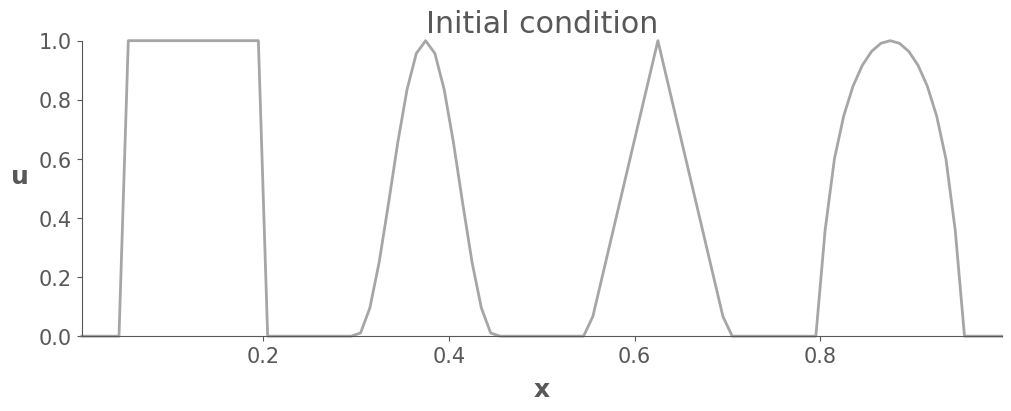

In [20]:
# Visualize the initial condition

L = 1.0
N = 100
dx = L / N
x = np.linspace(0+0.5*dx, L-0.5*dx, N)
u0 = np.zeros_like(x)

# Unit step
u0 = np.where(np.logical_and(x >= 0.05, x <= 0.2), 1, 0)

# Cosine
xStart = 0.3
xEnd = 0.45
L = xEnd - xStart
uCosine = 0.5 * (1 - np.cos(2 * np.pi * (x - xStart) / L))
u0 = np.where(np.logical_and(x >= xStart, x <= xEnd), uCosine, u0)

# linear spike
xStart = 0.55
xEnd = 0.7
xMid = (xStart + xEnd) / 2
L = xEnd - xStart
uSpike = 1 - 2 * np.abs(x - xMid) / L
# uSpike = np.exp(-50 * (np.abs(x - xMid) / L)**2)
u0 = np.where(np.logical_and(x >= xStart, x <= xEnd), uSpike, u0)

# hemisphere
xStart = 0.8
xEnd = 0.95
xMid = (xStart + xEnd) / 2
uHemi = np.sqrt(1 - (2 * (x - xMid) / L) ** 2)
print()
u0 = np.where(np.logical_and(x >= xStart, x <= xEnd), uHemi, u0)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")
ax.plot(x, u0, label="Initial condition", c="gray", alpha=0.7, clip_on=False)

ax.set_title("Initial condition")

In [21]:
def solve_linear_advection_1D(u0, n_timesteps, a, dx, CFL, flux_limiter):
    """ Solve the linear advection equation
        \partial{u}/\partial{t} + a \partial{u}/\partial{x} = 0
    """

    dt = CFL * dx / a
    n_cells = len(u0)

    u_all = jnp.zeros((n_timesteps, n_cells))

    u = u0.copy()

    @jit
    def update_fn(i, carry):
        u, u_all = carry

        f = a * u

        # Compute r
        ul = jnp.roll(u, 1)
        ur = jnp.roll(u, -1)

        r = (u - ul) / (ur - u + 1e-8)
        phi = flux_limiter(jnp.expand_dims(r, 1))
        phi = phi.squeeze()

        # First-order upwind
        F_low = 0.5 * (f + jnp.roll(f, -1)) - 0.5 * jnp.abs(a) * (jnp.roll(u, -1) - u)
        # Lax-Wendroff
        F_high = f + 0.5 * (1 - CFL) * (jnp.roll(f, -1) - f)
        F = (1 - phi) * F_low + phi * F_high
        u -= dt/dx * (F - jnp.roll(F, 1))
        u_all = u_all.at[i].set(u.copy())

        return u, u_all

    carry = u, u_all
    u, u_all = lax.fori_loop(0, n_timesteps, update_fn, carry)

    return u, u_all

MSE of Upwind: 0.12648717330059678
MSE of Lax-Wendroff: 0.04170115399056601
MSE of Minmod: 0.031062763782736105
MSE of van Leer: 0.015037382150857917
MSE of Superbee: 0.007042711886863323
MSE of Neural flux limiter: 0.011023073754425206


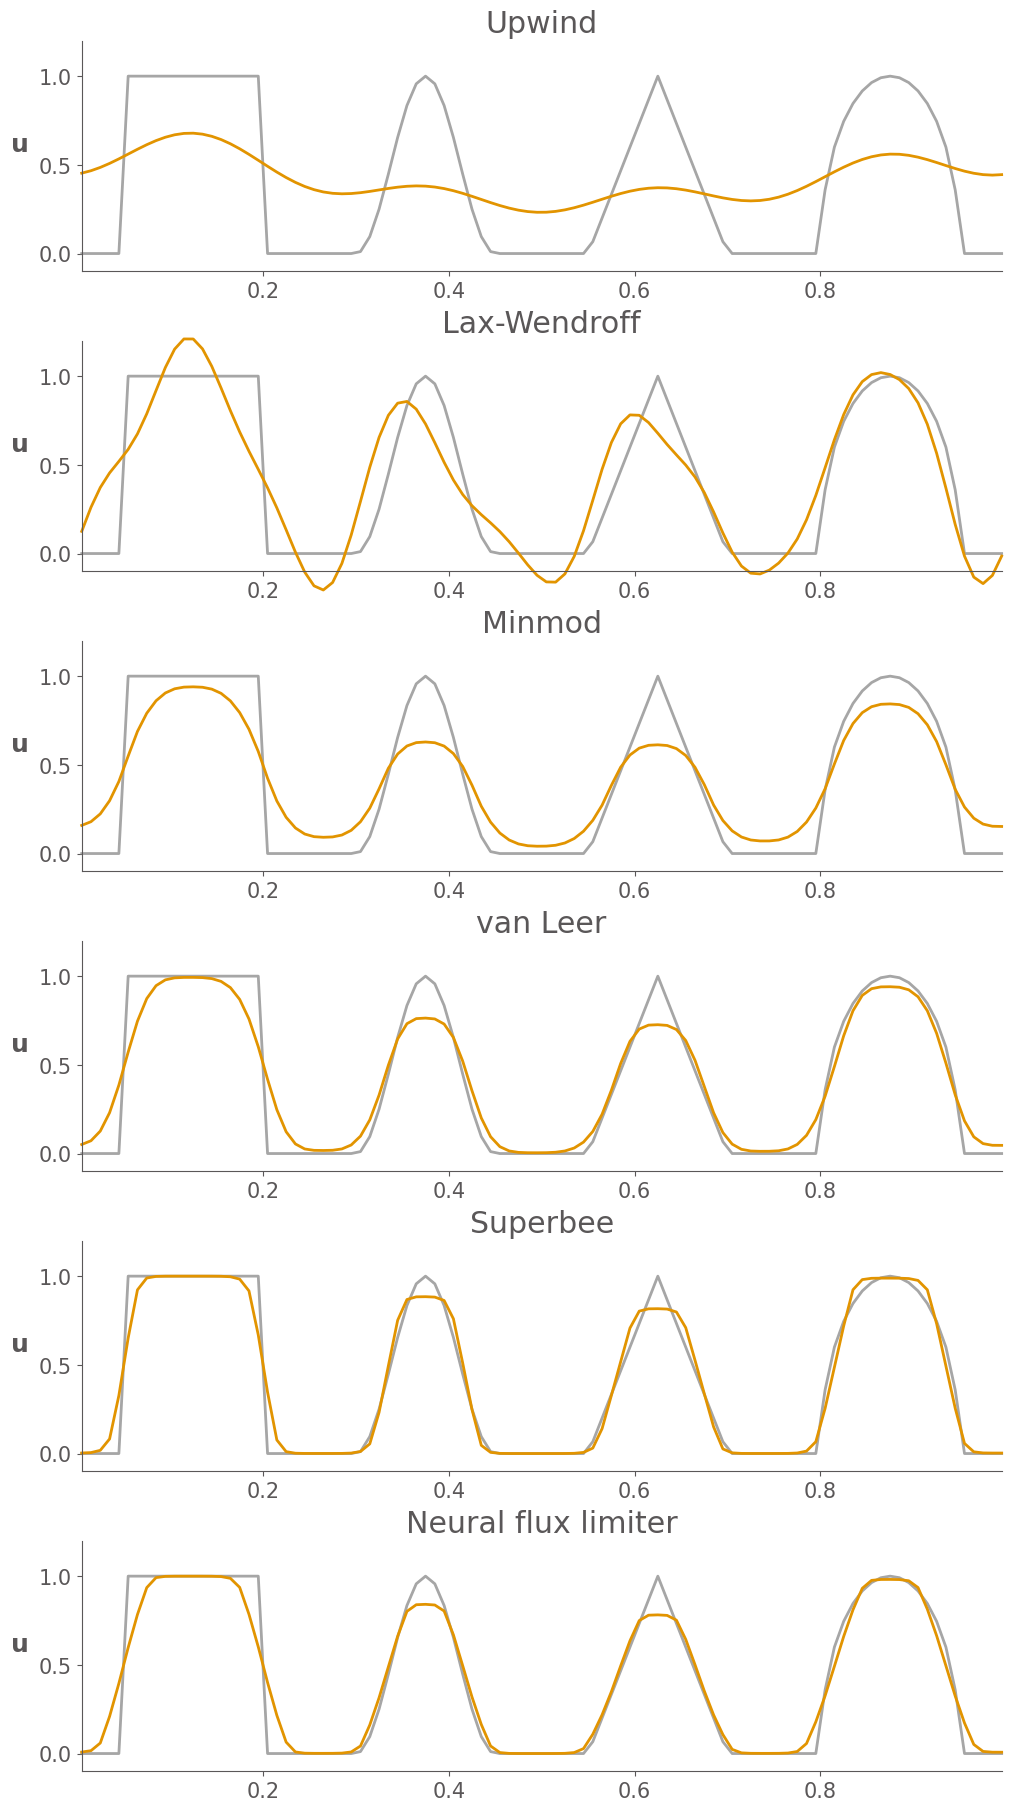

In [22]:
# Test performance
a = 1.0
CFL = 0.4
dt = CFL * dx / a
n_timesteps = int(1.0/dt)


schemes = {
    "Upwind": FOU,
    "Lax-Wendroff": LaxWendroff,
    "Minmod": minmod,
    "van Leer": vanLeer,
    "Superbee": superbee,
    "Neural flux limiter": functools.partial(flux_limiter.apply, state.params)
}

fig, axes = plt.subplots(nrows=len(schemes), figsize=(10, 3 * len(schemes)))

for ax, (name, scheme) in zip(axes, schemes.items()):
    # ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")
    ax.plot(x, u0, label="Initial condition", c="gray", alpha=0.7, clip_on=False)

    u, _ = solve_linear_advection_1D(u0, n_timesteps=int(1.0/dt), a=1.0, dx=dx, CFL=0.4, flux_limiter=scheme)
    ax.plot(x, u, label=name, clip_on=False)
    ax.set_title(name)
    ax.set_ylim(-0.1, 1.2)

    print(f"MSE of {name}: {np.sum(np.abs(u - u0)**2)/u.size}")

Some observations from these results:

* First order upwind is overly diffusive, and smears out the waves

* Lax-Wendroff introduce unphysical oscilations, particularly near shocks

* Of the four limited schemes, minmod is the most diffusive.

* Superbee is the least diffusive, maintaining shocks well, but also seems to “over-sharpen” some of the smoother waves

* The Van Leer limiter is a good compromise between minmod and superbee, maintaining shocks well, without much over-sharpening.

* The learned neural flux limiter is less diffusive than van Leer and less over-shaperning than superbee.

* From MSE, we see that the accuracy of the learned neural flux limiter outperforms all of the other flux limiters except for superbee, though it is not even trained on this initial condition. This suggested that the learned flux limiter has great generalization ability.